In [1]:
#from __future__ import absolute_import, division, print_function, unicode_literals
# Installa TensorFlow
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)


2.4.1


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D
import numpy as np

Para leer datos lo mejor es usar la toolbox pandas

Los datos se han sacado de:
https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/version/3

In [5]:
import pandas as pd

# Leer los datos 
# En local: tenemos que tener el fichero en la misma carpeta que el notebook (o cambiar la ruta)
# En Colab: abre la carpeta (usando el boton de la izquierda) y arrastralos dentro desde tu ordenador.

dd_googl = pd.read_csv("googl.us.txt", delimiter=",")
dd_aa = pd.read_csv("aa.us.txt", delimiter=",")
dd_iae = pd.read_csv("iae.us.txt", delimiter=",")


In [6]:
# Estos son los datos de google
dd_googl

,Date,Open,High,Low,Close,Volume,OpenInt
0,2004-08-19,50.000,52.03,47.980,50.170,44703800,0
1,2004-08-20,50.505,54.54,50.250,54.155,22857200,0
2,2004-08-23,55.375,56.74,54.525,54.700,18274400,0
3,2004-08-24,55.620,55.80,51.785,52.435,15262600,0
4,2004-08-25,52.480,54.00,51.940,53.000,9197800,0
...,...,...,...,...,...,...,...
3328,2017-11-06,1049.100,1052.59,1042.000,1042.680,913954,0
3329,2017-11-07,1049.650,1053.41,1043.000,1052.390,1303832,0
3330,2017-11-08,1050.050,1062.69,1047.050,1058.290,1214469,0
3331,2017-11-09,1048.000,1050.88,1035.850,1047.720,1793994,0


In [7]:
# Nos quedamos con los datos de apertura
googl_op = dd_googl['Open'].values
aa_op = dd_aa['Open'].values
iae_op = dd_iae['Open'].values

In [8]:
# Como no coinciden en el tiempo los 3 valores me cojo solo los que coinciden
# Primero me los ordeno teniendo en cuenta la fecha
aa = dd_googl['Date'].values
googl_indice = np.zeros(aa.shape)
for n in range(0, aa.shape[0]):
    cc = aa[n]
    qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
    qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
    qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

    googl_indice[n] = (qq1-2000)*365 + qq2*30 + qq3

In [9]:
aa = dd_aa['Date'].values
aa_indice = np.zeros(aa.shape)
for n in range(0, aa.shape[0]):
    cc = aa[n]
    qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
    qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
    qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

    aa_indice[n] = (qq1-2000)*365 + qq2*30 + qq3

In [10]:
aa = dd_iae['Date'].values
iae_indice = np.zeros(aa.shape)
for n in range(0, aa.shape[0]):
    cc = aa[n]
    qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
    qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
    qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

    iae_indice[n] = (qq1-2000)*365 + qq2*30 + qq3

In [11]:
print(googl_indice.shape)
print(googl_op.shape)

(3333,)
(3333,)


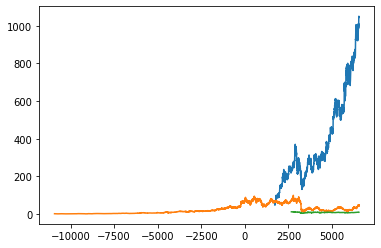

In [12]:
# Los ploteo y veo que hay un tramo en el coinciden las fechas
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(googl_indice,googl_op)
plt.plot(aa_indice,aa_op)
plt.plot(iae_indice,iae_op)

In [13]:
# Me quedo solo las fechas que coinciden
indices = set(googl_indice) & set(aa_indice) & set(iae_indice) 

ii = np.in1d(googl_indice,list(indices))
data_googl = googl_op[ii]
ii = np.in1d(aa_indice,list(indices))
data_aa = aa_op[ii]
ii = np.in1d(iae_indice,list(indices))
data_iae = iae_op[ii]

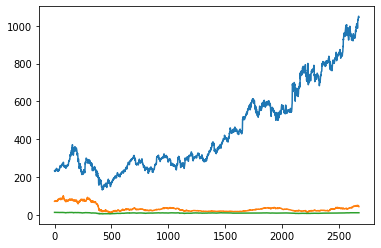

In [14]:
# Los ploteo y ahora síí coinciden en todo el tramo
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(data_googl)
plt.plot(data_aa)
plt.plot(data_iae)

In [15]:
# Los coloco todos juntos en un dataset
DAT = np.zeros((data_googl.shape[0],3))
DAT[:,0] = data_googl
DAT[:,1] = data_aa
DAT[:,2] = data_iae
               

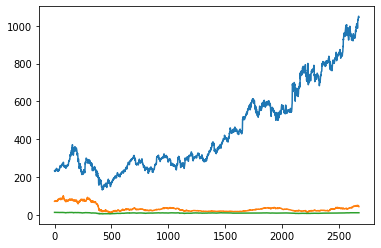

In [16]:
# Los ploteo
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(DAT[:,0])
plt.plot(DAT[:,1])
plt.plot(DAT[:,2])

In [17]:
# Dimensiones del dataset
DAT.shape

(2678, 3)

In [19]:
# Reordeno el dataset para hacer bloques de LAG dias
LAG = 15
DAT_TS = np.zeros((DAT.shape[0]-LAG,LAG,DAT.shape[1]))

for ii in range(0,DAT.shape[0]-LAG):
    DAT_TS[ii,:,:] = DAT[ii:ii+LAG,:]
    

In [20]:
# Tengo (#muestras,#longitud,#variables)
DAT_TS.shape

(2663, 15, 3)

In [21]:
# Cojo 14 dias para entrada y el dia 15 de la variable "Y_target" como variable a predecir
# Separo en train y test

Ntr = np.floor(DAT_TS.shape[0]/2)
Y_target = 0

XX_tr = DAT_TS[range(0,np.int(Ntr)),0:LAG-1,:]
XX_ts = DAT_TS[range(np.int(Ntr)+1,2*np.int(Ntr)),0:LAG-1,:]

YY_tr = DAT_TS[range(0,np.int(Ntr)),LAG-1,Y_target]
YY_ts = DAT_TS[range(np.int(Ntr)+1,2*np.int(Ntr)),LAG-1,Y_target]

LAG-1

14

In [22]:
# Los datos de entrada
XX_tr.shape

(1331, 14, 3)

In [23]:
# Los datos a predecir
YY_tr.shape

(1331,)

In [24]:
# Modifico las dimensiones para poder usar convoluciones 2D
# Para eso incluyo una dimension de canales al final

XX_tr = XX_tr.reshape(XX_tr.shape[0],XX_tr.shape[1],XX_tr.shape[2],1)
XX_ts = XX_ts.reshape(XX_ts.shape[0],XX_ts.shape[1],XX_ts.shape[2],1)

In [25]:
XX_tr.shape

(1331, 14, 3, 1)

KERAS MODEL

In [28]:
# Definimos un modelo con una capa convolucional 2D y 1 capa densa
model = Sequential()
model.add(Conv2D(10, 3, input_shape=XX_tr.shape[1:], padding='same'))
model.add(Flatten())
model.add(Dense(1))

# mostramos el modelo
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 3, 10)         100       
_________________________________________________________________
flatten_2 (Flatten)          (None, 420)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 421       
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Otra posibilidad 2 convolucionales 2D y una densa
model = Sequential()
model.add(Conv2D(10, 3, input_shape=XX_tr.shape[1:], padding='same'))
model.add(Conv2D(10, 3, padding='same'))
model.add(Flatten())
model.add(Dense(1))

# mostramos el modelo
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 3, 10)         100       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 3, 10)         910       
_________________________________________________________________
flatten_2 (Flatten)          (None, 420)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 421       
Total params: 1,431
Trainable params: 1,431
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Otra posibilidad 2 convolucionales 2D y 2 densas
model = Sequential()
model.add(Conv2D(10, 3, input_shape=XX_tr.shape[1:], padding='same'))
model.add(Conv2D(10, 3, padding='valid'))
model.add(Flatten())
model.add(Dense(10))
model.add(Dense(1))

# mostramos el modelo
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 3, 10)         100       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 1, 10)         910       
_________________________________________________________________
flatten_4 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1210      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 2,231
Trainable params: 2,231
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Compilamos el modelo
model.compile(optimizer='adam',loss='mae')

In [30]:
# Entrenamos el modelo. Para guardarnos la evolucióón usando callbacks

# from keras.callbacks import History 
# history = History()

# model.fit(XX_tr, YY_tr, batch_size=32, epochs=100, verbose=1, callbacks=[history])

In [31]:
# Entrenamos el modelo, nos guardamos la evolución en 'history' 
# Esto es equivalente a usar callbacks para history
history = model.fit(XX_tr, YY_tr, batch_size=32, epochs=300, verbose=1)

Epoch 1/300
42/42 [==============================] - 1s 2ms/step - loss: 149.3017
Epoch 2/300
42/42 [==============================] - 0s 2ms/step - loss: 12.4916
Epoch 3/300
42/42 [==============================] - 0s 2ms/step - loss: 8.4333
Epoch 4/300
42/42 [==============================] - 0s 2ms/step - loss: 8.5310
Epoch 5/300
42/42 [==============================] - 0s 2ms/step - loss: 7.9168
Epoch 6/300
42/42 [==============================] - 0s 2ms/step - loss: 7.8489
Epoch 7/300
42/42 [==============================] - 0s 2ms/step - loss: 7.4536
Epoch 8/300
42/42 [==============================] - 0s 2ms/step - loss: 7.2524
Epoch 9/300
42/42 [==============================] - 0s 2ms/step - loss: 7.2393
Epoch 10/300
42/42 [==============================] - 0s 2ms/step - loss: 6.7841
Epoch 11/300
42/42 [==============================] - 0s 2ms/step - loss: 6.0370
Epoch 12/300
42/42 [==============================] - 0s 2ms/step - loss: 6.1325
Epoch 13/300
42/42 [==============

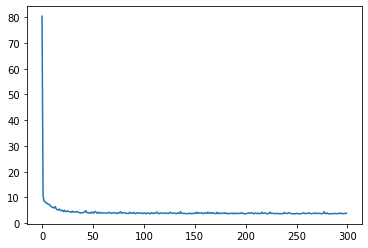

In [32]:
# Mostramos la evolucióón del entrenamiento
loss_ev = history.history['loss']

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(loss_ev)

In [33]:
# Evaluamos el modelo en train
score = model.evaluate(XX_tr, YY_tr, verbose=0)
score

3.676746368408203

In [34]:
# Predecimos con los datos de train
y_hat = model.predict(XX_tr)
np.mean(abs(y_hat[:,0]-YY_tr))

3.676746219488841

In [35]:
y_hat.shape

(1331, 1)

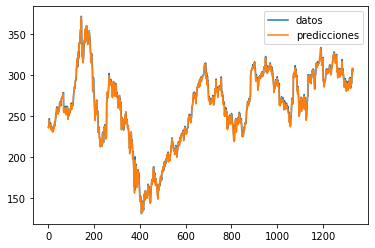

In [36]:
# Mostramos las predicciones
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(y_hat, label='datos')
plt.plot(YY_tr, label='predicciones')
plt.legend()

TEST

In [37]:
# Predecimos en test
y_hat = model.predict(XX_ts)
# mostramos el error
np.mean(abs(y_hat[:,0]-YY_ts))

6.3180310829564155

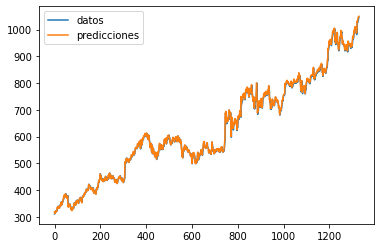

In [39]:
# Mostramos las predicciones
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(y_hat, label='datos')
plt.plot(YY_ts, label='predicciones')
plt.legend()

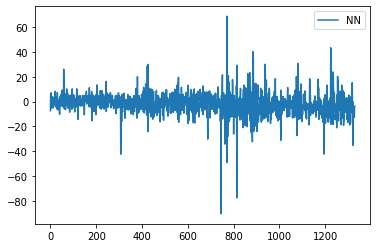

In [40]:
# Estas son las diferencias
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(y_hat[:,0]-YY_ts, label='NN')
plt.legend()